## Data Exploration

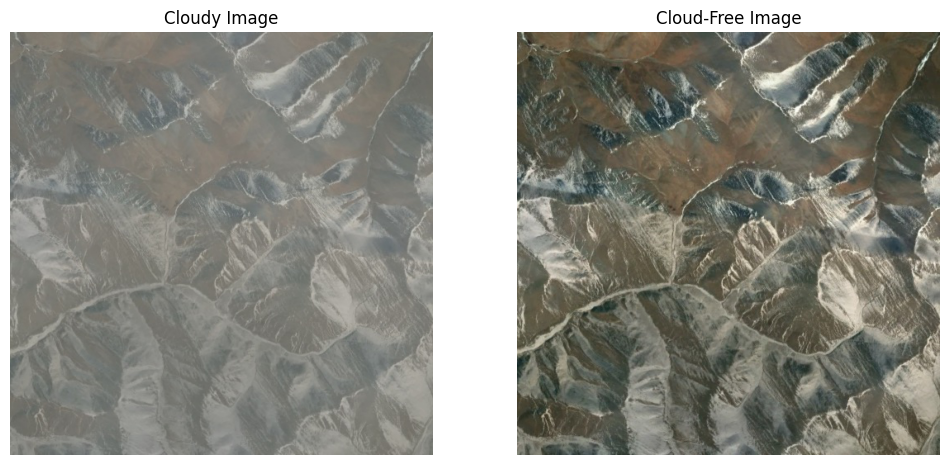

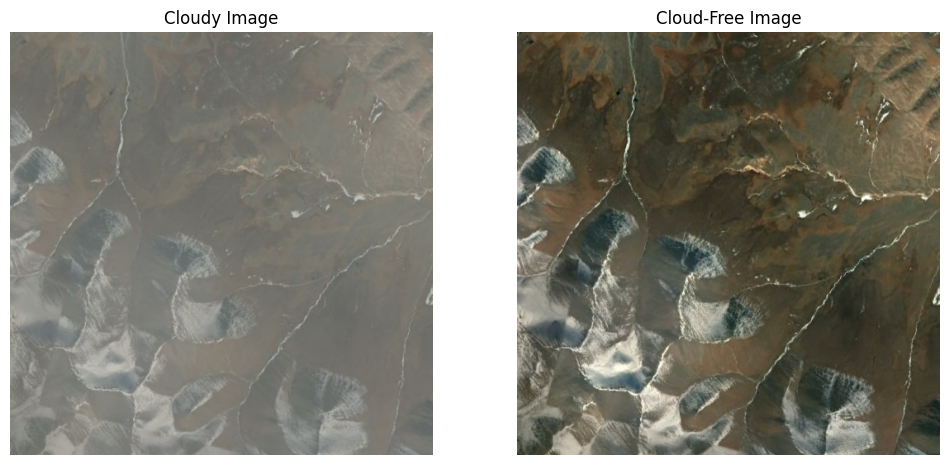

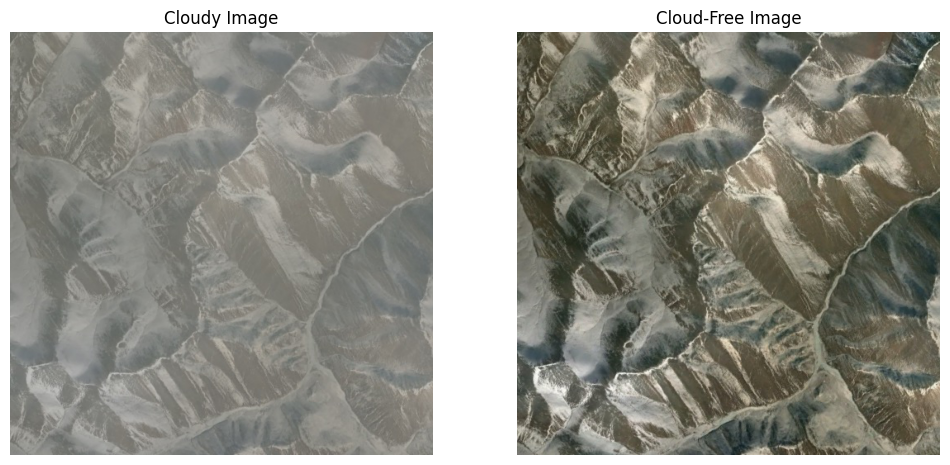

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define paths to the dataset
data_dir = '/Users/ldcrainic/University/MSc-Courses/ComputerVision/data/RICE1'
cloudy_images_dir = os.path.join(data_dir, 'cloud')
cloud_free_images_dir = os.path.join(data_dir, 'label')

# List files in the directories
cloudy_images = sorted(os.listdir(cloudy_images_dir))
cloud_free_images = sorted(os.listdir(cloud_free_images_dir))

# Display some sample images
def display_samples(cloudy_img_path, cloud_free_img_path):
    cloudy_image = Image.open(cloudy_img_path)
    cloud_free_image = Image.open(cloud_free_img_path)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cloudy_image)
    axes[0].set_title('Cloudy Image')
    axes[0].axis('off')

    axes[1].imshow(cloud_free_image)
    axes[1].set_title('Cloud-Free Image')
    axes[1].axis('off')

    plt.show()

# Show a few samples
for i in range(3):  # Display first 3 samples
    display_samples(os.path.join(cloudy_images_dir, cloudy_images[i]),
                    os.path.join(cloud_free_images_dir, cloud_free_images[i]))


In [2]:
# Load one sample image
sample_image = Image.open(os.path.join(cloudy_images_dir, cloudy_images[0]))

# Print image properties
print(f"Image size: {sample_image.size}")
print(f"Image mode (color channels): {sample_image.mode}")
print(f"Pixel value range: {sample_image.getextrema()}")

Image size: (512, 512)
Image mode (color channels): RGB
Pixel value range: ((90, 196), (95, 195), (90, 191))


In [3]:
# Check if the number of images matches
assert len(cloudy_images) == len(cloud_free_images), "Mismatch in the number of images!"

# Check for matching file names (assuming they are named consistently)
for cloudy, cloud_free in zip(cloudy_images, cloud_free_images):
    assert cloudy.split('.')[0] == cloud_free.split('.')[0], f"Mismatch: {cloudy} and {cloud_free}"
print("All image pairs are matched.")

All image pairs are matched.


In [4]:
from torchvision import transforms

def get_transforms():
    # Define the transformations
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)), # Resize images to a fixed size
        transforms.ToTensor(),         # Convert PIL image to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize to [-1, 1]
    ])

    # Define augmentation transformations (if needed)
    augment = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20)
    ])

    return preprocess, augment

preprocess, augment = get_transforms()

In [5]:
# Apply preprocessing to a sample image
transformed_image = preprocess(sample_image)
print(f"Transformed image shape: {transformed_image.shape}")


Transformed image shape: torch.Size([3, 256, 256])


In [6]:
from torch.utils.data import Dataset, DataLoader
import torch

class RiceDataset(Dataset):
    def __init__(self, cloudy_dir, cloud_free_dir, transform=None, augment=None):
        self.cloudy_dir = cloudy_dir
        self.cloud_free_dir = cloud_free_dir
        self.transform = transform
        self.augment = augment
        self.cloudy_images = sorted(os.listdir(cloudy_dir))
        self.cloud_free_images = sorted(os.listdir(cloud_free_dir))

    def __len__(self):
        return len(self.cloudy_images)

    def __getitem__(self, idx):
        cloudy_path = os.path.join(self.cloudy_dir, self.cloudy_images[idx])
        cloud_free_path = os.path.join(self.cloud_free_dir, self.cloud_free_images[idx])
        
        # Load images
        cloudy_image = Image.open(cloudy_path)
        cloud_free_image = Image.open(cloud_free_path)

        # Apply augmentations if provided
        if self.augment:
            cloudy_image = self.augment(cloudy_image)
            cloud_free_image = self.augment(cloud_free_image)

        # Apply preprocessing
        if self.transform:
            cloudy_image = self.transform(cloudy_image)
            cloud_free_image = self.transform(cloud_free_image)

        return cloudy_image, cloud_free_image

# Create dataset instance and DataLoader
rice_dataset = RiceDataset(cloudy_images_dir, cloud_free_images_dir, transform=preprocess, augment=augment)
data_loader = DataLoader(rice_dataset, batch_size=8, shuffle=True)

# Test the DataLoader
batch = next(iter(data_loader))
print(f"Cloudy images batch shape: {batch[0].shape}")
print(f"Cloud-free images batch shape: {batch[1].shape}")


Cloudy images batch shape: torch.Size([8, 3, 256, 256])
Cloud-free images batch shape: torch.Size([8, 3, 256, 256])


### Model implementation
We are going to implement a simple model to start exploring the data. The model is going to be a  U-Net architecture.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongCS/UNet-AE/issues/1
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


In [9]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [10]:
# Create a sample batch of images (e.g., 1 image of size 3x256x256)
sample_input = torch.randn(1, 3, 256, 256)  # [batch_size, channels, height, width]

# Initialize the U-Net model
model = UNet(n_channels=3, n_classes=3)  # 3 input channels (RGB), 3 output channels

# Test the model with the sample input
sample_output = model(sample_input)
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])


### Training Setup

In [11]:
# Import necessary libraries
import torch.optim as optim

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
from tqdm import tqdm

# Function for one training epoch
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    
    for i, (cloudy_images, cloud_free_images) in enumerate(tqdm(dataloader)):
        # Move data to the device (GPU or CPU)
        cloudy_images, cloud_free_images = cloudy_images.to(device), cloud_free_images.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(cloudy_images)

        # Compute loss
        loss = criterion(outputs, cloud_free_images)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()
    
    # Calculate average loss
    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [13]:
# Function for one validation epoch
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for cloudy_images, cloud_free_images in dataloader:
            # Move data to the device (GPU or CPU)
            cloudy_images, cloud_free_images = cloudy_images.to(device), cloud_free_images.to(device)

            # Forward pass
            outputs = model(cloudy_images)

            # Compute loss
            loss = criterion(outputs, cloud_free_images)

            # Accumulate loss
            running_loss += loss.item()
    
    # Calculate average loss
    epoch_loss = running_loss / len(dataloader)
    return epoch_loss


In [14]:
from torch.utils.data import random_split

# Split dataset into training and validation
train_size = int(0.8 * len(rice_dataset))
val_size = len(rice_dataset) - train_size
train_dataset, val_dataset = random_split(rice_dataset, [train_size, val_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [15]:
# Train for one epoch
train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
print(f"Training Loss: {train_loss:.4f}")

# Validate for one epoch
val_loss = validate_epoch(model, val_loader, criterion, device)
print(f"Validation Loss: {val_loss:.4f}")


100%|██████████| 50/50 [09:58<00:00, 11.97s/it]


Training Loss: 0.1419
Validation Loss: 0.0879


In [16]:
# Number of epochs to train
num_epochs = 20

# Initialize lists to store loss values for visualization
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    print(f"Training Loss: {train_loss:.4f}")

    # Validate for one epoch
    val_loss = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")


Epoch 1/20


100%|██████████| 50/50 [10:02<00:00, 12.05s/it]


Training Loss: 0.1258
Validation Loss: 0.0832
Epoch 2/20


100%|██████████| 50/50 [07:51<00:00,  9.43s/it]


Training Loss: 0.1141
Validation Loss: 0.0866
Epoch 3/20


100%|██████████| 50/50 [08:03<00:00,  9.67s/it]


Training Loss: 0.1060
Validation Loss: 0.0977
Epoch 4/20


 84%|████████▍ | 42/50 [07:20<01:23, 10.49s/it]


KeyboardInterrupt: 